## Imports and Data Loading

### Imports

In [104]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold, KFold, cross_val_predict
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import confusion_matrix, mean_squared_error
import seaborn as sns
from IPython.display import display, HTML
from sklearn.metrics import roc_auc_score, roc_curve, recall_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import RFE  # Recursive Feature Elimination for feature selection
from catboost import CatBoostClassifier
from sklearn.preprocessing import MinMaxScaler
from matplotlib.ticker import ScalarFormatter
from sklearn.neural_network import MLPClassifier

### Loading 2013-2014 NHANES Data

In [105]:
# Read the CSV files into dfs
df1 = pd.read_csv('questionnaire.csv')
df2 = pd.read_csv('demographic.csv')
df3 = pd.read_csv('diet.csv')
df4 = pd.read_csv('examination.csv')

### Loading 2015-2016

In [106]:
df15_16 = pd.read_csv('merged_data.csv')
# Set numbers between 0 and 0.0001 to 0
df15_16 = df15_16.applymap(lambda x: 0 if isinstance(x, (int, float)) and 0 < x < 0.0001 else x)

C:\Users\samco\AppData\Local\Temp\ipykernel_22608\4020531852.py:3: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df15_16 = df15_16.applymap(lambda x: 0 if isinstance(x, (int, float)) and 0 < x < 0.0001 else x)


### Loading 2011-12 

In [107]:
df_11_12 = pd.read_csv('merged_2011_2012.csv')

df_11_12 = df_11_12.applymap(lambda x: 0 if isinstance(x, (int, float)) and 0 < x < 0.0001 else x)

C:\Users\samco\AppData\Local\Temp\ipykernel_22608\3453741107.py:3: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_11_12 = df_11_12.applymap(lambda x: 0 if isinstance(x, (int, float)) and 0 < x < 0.0001 else x)


### Loading 2017-18 

In [108]:
df_17_18 = pd.read_csv('merged_2017_2018.csv')

df_17_18 = df_17_18.applymap(lambda x: 0 if isinstance(x, (int, float)) and 0 < x < 0.0001 else x)

C:\Users\samco\AppData\Local\Temp\ipykernel_22608\1951393457.py:3: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_17_18 = df_17_18.applymap(lambda x: 0 if isinstance(x, (int, float)) and 0 < x < 0.0001 else x)


### Merging Data into single DF

In [109]:
# Merge the dfs on the 'seqn' column
df = df1.merge(df2, on='SEQN').merge(df3, on='SEQN').merge(df4, on='SEQN')

print(df.shape)

df = pd.concat([df, df_11_12], ignore_index=True)
# df = pd.concat([df, df_11_12], ignore_index=True)

# Print the merged df
print(df1.shape)
print(df2.shape)
print(df3.shape)
print(df4.shape)
print(df.shape)


(9813, 1389)
(10175, 953)
(10175, 47)
(9813, 168)
(9813, 224)
(19569, 1417)


### Choosing columns

In [110]:
# List of columns to keep
columns_to_keep = [
    'SEQN', 'RIAGENDR', 'RIDAGEYR', 'DMDEDUC2', 'BPXDI1', 'BPXDI2', 'BPXDI3', 'BPXSY1', 'BPXSY2', 'BPXSY3', 'BMXBMI', 'BMXHT', 'BMXWAIST', 'BMXWT', 'BPQ080',
    'DRQSPREP', 'DIQ010','PAQ650', 'PAQ665', 'ALQ101','ALQ151', 'ALQ120Q', 'ALQ120U', 'ALQ130', 'SMQ020', 'SMQ040', 'DBQ700', 'HSD010', 'SMQ050Q', 'SMQ050U', 'SMD055', 'SMD057', 'SMD641', 'SMD650', 'SMD030'
]

# Drop all columns except for the specified ones
df = df[columns_to_keep]

df15_16 = df15_16[columns_to_keep]

# Drop all rows where RIDAGEYR is less than 18
df = df[df['RIDAGEYR'] >= 18]

df15_16 = df15_16[df15_16['RIDAGEYR'] >= 18]

df.head()

,SEQN,RIAGENDR,RIDAGEYR,DMDEDUC2,BPXDI1,BPXDI2,BPXDI3,BPXSY1,BPXSY2,BPXSY3,...,SMQ040,DBQ700,HSD010,SMQ050Q,SMQ050U,SMD055,SMD057,SMD641,SMD650,SMD030
0,73557.0,1.0,69.0,3.0,72.0,76.0,74.0,122.0,114.0,102.0,...,3.0,2.0,2.0,3.0,4.0,66.0,2.0,NaN,NaN,17.0
1,73558.0,1.0,54.0,3.0,62.0,80.0,42.0,156.0,160.0,156.0,...,2.0,3.0,4.0,NaN,NaN,NaN,NaN,1.0,1.0,0.0
2,73559.0,1.0,72.0,4.0,90.0,76.0,80.0,140.0,140.0,146.0,...,3.0,3.0,3.0,40.0,4.0,26.0,3.0,NaN,NaN,20.0
4,73561.0,2.0,73.0,5.0,86.0,88.0,86.0,136.0,134.0,142.0,...,NaN,2.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,73562.0,1.0,56.0,4.0,84.0,82.0,80.0,160.0,158.0,154.0,...,3.0,5.0,5.0,16.0,4.0,40.0,5.0,NaN,NaN,18.0


### Filling nulls that can be imputed

In [111]:
# Filling Nulls Due to Skip Questions
df.loc[df['ALQ101'] == 2, ['ALQ120U', 'ALQ120Q', 'ALQ130']] = df.loc[df['ALQ101'] == 2, ['ALQ120U', 'ALQ120Q', 'ALQ130']].fillna(0)
df.loc[df['ALQ101'] == 2, ['ALQ151']] = df.loc[df['ALQ101'] == 2, ['ALQ151']].fillna(2)
df.loc[df['ALQ120Q'] == 0, ['ALQ130']] = df.loc[df['ALQ120Q'] == 0, ['ALQ130']].fillna(0)

df.loc[df['SMQ020'] != 1, ['SMQ040']] = df.loc[df['SMQ020'] != 1, ['SMQ040']].fillna(3)

df.loc[df['ALQ120Q'] <= 3, ['ALQ130']] = df.loc[df['ALQ120Q'] <= 3, ['ALQ130']].fillna(0)

# Filling Nulls Due to Skip Questions
df15_16.loc[df15_16['ALQ101'] == 2, ['ALQ120U', 'ALQ120Q', 'ALQ130']] = df15_16.loc[df15_16['ALQ101'] == 2, ['ALQ120U', 'ALQ120Q', 'ALQ130']].fillna(0)
df15_16.loc[df15_16['ALQ101'] == 2, ['ALQ151']] = df15_16.loc[df15_16['ALQ101'] == 2, ['ALQ151']].fillna(2)
df15_16.loc[df15_16['ALQ120Q'] == 0, ['ALQ130']] = df15_16.loc[df15_16['ALQ120Q'] == 0, ['ALQ130']].fillna(0)

df15_16.loc[df15_16['SMQ020'] != 1, ['SMQ040']] = df15_16.loc[df15_16['SMQ020'] != 1, ['SMQ040']].fillna(3)

df15_16.loc[df15_16['ALQ120Q'] <= 3, ['ALQ130']] = df15_16.loc[df15_16['ALQ120Q'] <= 3, ['ALQ130']].fillna(0)



### Improving Column Names

In [112]:
# Rename the columns as specified
new_column_names = {
    'SEQN': 'ID',
    'RIAGENDR': 'Gender',
    'RIDAGEYR': 'Age',
    'BPXDI1': 'DiasBP1',
    'BPXDI2': 'DiasBP2',
    'BPXDI3': 'DiasBP3',
    'BPXSY1': 'SysBP1',
    'BPXSY2': 'SysBP2',
    'BPXSY3': 'SysBP3',
    'BMXBMI': 'BMI',
    'BMXHT': 'Height',
    'BMXWAIST': 'Waist',
    'BMXWT': 'Weight',
    'BPQ080': 'Cholesterol',
    'DRQSPREP': 'SaltFreq',
    'PAQ650': 'VigActivity',
    'PAQ665': 'ModActivity',
    'ALQ151': 'AlcConsumpMoreThan4/5MostDays',
    'ALQ120Q': 'AlcConsumpFreq',
    'ALQ120U' : 'UnitAlc',
    'ALQ130': 'AlcConsumpAmtPerDrinkDay',
    'SMQ020': '100Cigs',
    'DBQ700': 'OvrDietHealth',
    'HSD010': 'GenHealth',
    'SMQ040': 'Smoker',
    'DMDEDUC2': 'EducationLvl',
    'DIQ010' : 'Diabetes',
    'SMD030' : 'AgeStartedSmokingReg',
    'SMQ050Q': 'TimeQuit',
    'SMD055': 'AgeLastSmokedReg',
    'SMD057': 'WhenSmokedCigs/Day',
    'SMD641': 'DaysSmokedInLast30',
    'SMD650': 'AvgCigs/DayInLast30'
}

df.rename(columns=new_column_names, inplace=True)

df15_16.rename(columns=new_column_names, inplace=True)


## Feature Descriptions

### Cholesterol
- **Question:** Do you suffer from high cholesterol?

### Diet
- **Question:** Are you on a diet?

### Salt Frequency
- **Question:** How often do you add salt to your food?
  - 1 = Never
  - 2 = Rarely
  - 3 = Occasionally
  - 4 = Very Often

### Asthma
- **Question:** Have you ever been told you have asthma? (Refer to MCQ035 to check if you still have it)

### Stroke
- **Question:** Have you ever had a stroke?

### Vigorous Activity
- **Question:** Do you engage in any vigorous activity?

### Moderate Activity
- **Question:** Do you engage in any moderate activity?

### Over the Last 2 Weeks...
- **FeelPoorEating:** Have you been bothered by poor eating or appetite?
- **FeelTired:** Have you felt tired?
- **SleepTroubles:** Have you struggled to fall asleep, stay asleep, or slept too much?
- **FeelDepressed:** Have you felt depressed?

### Alcohol Consumption
- **AlcConsumpMoreThan4/5MostDays:** Have you ever consumed more than 4/5 drinks on most days?
- **AlcConsumpFreq:** How many days have you consumed alcohol in the past year?
- **AlcConsumpAmtPerDrinkDay:** On days you drank in the last year, on average, how many drinks did you have?

### Smoking
- **SMD030:** Age started smoking regularly (skip if < 100 cigs)
  - 7-64
  - 0 = Never regular
  - 80 = 80+
- **Smoker:** Do you currently smoke?
  - 1 = Every day
  - 2 = Some days
  - 3 = Never
- **SMQ050Q:** How long since you quit? (Skip if smoker = 1/2)
- **SMD055:** Age last smoked regularly (skip if still smokes/< 100 cigs)
- **SMD057:** When did you smoke, how many? (Skip if still smokes/< 100 cigs)
  - 1-90
  - 95+
- **SMD641:** Days smoked in the past 30 days (skip if not a current smoker)
- **SMD650:** Average number of cigarettes per day in the past 30 days (skip if not a current smoker)

### Overall Diet Health
- **Question:** How would you rate the health of your diet?
  - 1 = Excellent
  - 2 = Very good
  - 3 = Good
  - 4 = Fair
  - 5 = Poor

### General Health
- **Question:** How would you rate your general health condition?
  - 1 = Excellent
  - 2 = Very good
  - 3 = Good
  - 4 = Fair
  - 5 = Poor

### Sleep During Work Days
- **Question:** How much sleep do you get during work days?
  - 2-11 hours
  - 12 = 12+ hours

### Education Level
- **Question:** What is the highest level of school that you have completed?
  - 1 = Less than grade 9
  - 2 = Less than matriculated
  - 3 = High school graduate
  - 4 = Some college degree
  - 5 = College graduate or higher

### Diabetes
- **Question:** Has a doctor ever told you that you have diabetes?
  - 1 = Yes
  - 2 = No
  - 3 = Borderline

### Prediabetic
- **Question:** Has a doctor ever told you that you are prediabetic?


# Data Exploration

In [113]:
df.isnull().sum()

ID                                  0
Gender                              0
Age                                 0
EducationLvl                      640
DiasBP1                          1230
DiasBP2                           913
DiasBP3                           906
SysBP1                           1230
SysBP2                            913
SysBP3                            906
BMI                               416
Height                            394
Waist                             940
Weight                            391
Cholesterol                       305
SaltFreq                         1279
Diabetes                            0
VigActivity                         0
ModActivity                         0
ALQ101                           1390
AlcConsumpMoreThan4/5MostDays    1397
AlcConsumpFreq                   1393
UnitAlc                          2532
AlcConsumpAmtPerDrinkDay         1393
100Cigs                           305
Smoker                              0
OvrDietHealt

In [114]:
def plot_bivariate(col, hue):
    if df[col].nunique() > 5:
        plt.figure(figsize=(20, 10))
        rot = 90
    else:
        plt.figure(figsize=(10, 7))
        rot = 0

    def percentage(ax):
        heights = [[p.get_height() for p in bars] for bars in ax.containers]  # Get the counts of each bar, make arrays when more than one in group
        min_length = min(len(group) for group in heights)  # Find the minimum length of the groups
        for bars in ax.containers:
            for i, p in enumerate(bars):
                if i >= min_length:
                    continue  # Skip if index is out of range for any group
                total = sum(group[i] for group in heights)  # Sum total of each group
                percentage = (100 * p.get_height() / total)  # Calculate % to annotate
                ax.annotate(format(p.get_height()), (p.get_x() + p.get_width() * 0.5, 0.8 * p.get_height()), 
                            ha='center', va='bottom', rotation=0)
                if percentage > 25.0:
                    percentage = f'{percentage:.1f}%'
                    ax.annotate(percentage, (p.get_x() + p.get_width() * 0.5, 0.25 * p.get_height()), 
                                ha='center', va='center', rotation=rot)

    plot = sns.countplot(x=df[col], hue=df[hue], palette='pastel')
    percentage(plot)
    plt.xticks(rotation=rot)
    plt.show()

In [115]:
def calculate_average(df, features, new_feature_name):
    # Check and select the relevant columns from the df
    relevant_columns = df[features].replace({0: np.nan})  # Replace zeros with NaN to exclude from mean calculation
    
    # Calculate the mean across the specified columns, ignoring NaN values
    df[new_feature_name] = relevant_columns.mean(axis=1, skipna=True)

## Creating BP features

In [116]:
diasBP_features = ['DiasBP1', 'DiasBP2', 'DiasBP3']
sysBP_features = ['SysBP1', 'SysBP2', 'SysBP3']

calculate_average(df, diasBP_features, 'AvgDiasBP')
calculate_average(df, sysBP_features, 'AvgSysBP')

calculate_average(df15_16, diasBP_features, 'AvgDiasBP')
calculate_average(df15_16, sysBP_features, 'AvgSysBP')

In [117]:
# Drop rows where AvgSysBP is null
df = df.dropna(subset=['AvgSysBP'])
df15_16 = df15_16.dropna(subset=['AvgSysBP'])

## Creating a Hypertension Variable

In [118]:
conditions = [
    df['AvgSysBP'] < 130,
    (df['AvgSysBP'] >= 130)
]
values = [0, 1]

# Use np.select to handle NaNs and assign the appropriate category
df['HypertensionLvl'] = np.select(conditions, values, default=np.nan)

conditions_df15_16 = [
    df15_16['AvgSysBP'] < 130,
    df15_16['AvgSysBP'] >= 130
]
df15_16['HypertensionLvl'] = np.select(conditions_df15_16, values, default=np.nan)

## Creating Smoking Features

In [119]:
df.loc[df['TimeQuit'] == 66666, 'TimeQuit'] = 50
df15_16.loc[df15_16['TimeQuit'] == 66666, 'TimeQuit'] = 50

In [120]:
# Define the transformation function
def transform_time_quit(row):
    if row['SMQ050U'] == 1:
        return 0
    elif row['SMQ050U'] == 2:
        return (row['TimeQuit'] / 52)
    elif row['SMQ050U'] == 3:
        return (row['TimeQuit'] / 12)
    else:
        return row['TimeQuit']

# Apply the transformation to the TimeQuit column
df['TimeQuit'] = df.apply(transform_time_quit, axis=1)
df15_16['TimeQuit'] = df15_16.apply(transform_time_quit, axis=1)

In [121]:
# Update AgeLastSmokedReg where it is null, TimeQuit is not null, and TimeQuit is smaller than 100
df.loc[(df['AgeLastSmokedReg'].isnull()) & (df['TimeQuit'].notnull()) & (df['TimeQuit'] < 100) & (df['Smoker'] == 3) & (df['100Cigs'] == 1), 'AgeLastSmokedReg'] = df['Age'] - df['TimeQuit']
df15_16.loc[(df15_16['AgeLastSmokedReg'].isnull()) & (df15_16['TimeQuit'].notnull()) & (df15_16['TimeQuit'] < 100) & (df15_16['Smoker'] == 3) & (df15_16['100Cigs'] == 1), 'AgeLastSmokedReg'] = df15_16['Age'] - df15_16['TimeQuit']

### Creating YearsSmoked Feature

In [122]:
df.loc[df['AgeStartedSmokingReg'] > 100, 'AgeStartedSmokingReg'] = np.nan
df15_16.loc[df15_16['AgeStartedSmokingReg'] > 100, 'AgeStartedSmokingReg'] = np.nan
df.loc[df['TimeQuit'] > 66666, 'TimeQuit'] = np.nan
df15_16.loc[df15_16['TimeQuit'] > 66666, 'TimeQuit'] = np.nan
df.loc[df['AgeLastSmokedReg'] > 100, 'AgeLastSmokedReg'] = np.nan
df15_16.loc[df15_16['AgeLastSmokedReg'] > 100, 'AgeLastSmokedReg'] = np.nan
df = df.drop(columns=['SMQ050U'])
df15_16 = df15_16.drop(columns=['SMQ050U'])

df['yearsSmoked'] = np.where(
    df['Smoker'].isin([1, 2]),
    df['Age'] - df['AgeStartedSmokingReg'],
    df['AgeLastSmokedReg'] - df['AgeStartedSmokingReg']
)
df15_16['yearsSmoked'] = np.where(
    df15_16['Smoker'].isin([1, 2]),
    df15_16['Age'] - df15_16['AgeStartedSmokingReg'],
    df15_16['AgeLastSmokedReg'] - df15_16['AgeStartedSmokingReg']
)

df['yearsSmoked'] = df['yearsSmoked'].fillna(0)
df15_16['yearsSmoked'] = df15_16['yearsSmoked'].fillna(0)

C:\Users\samco\AppData\Local\Temp\ipykernel_22608\3170566072.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  hypertension_percentage = df.groupby('yearsSmokedBinned')['HypertensionLvl'].value_counts(normalize=True).unstack().fillna(0) * 100


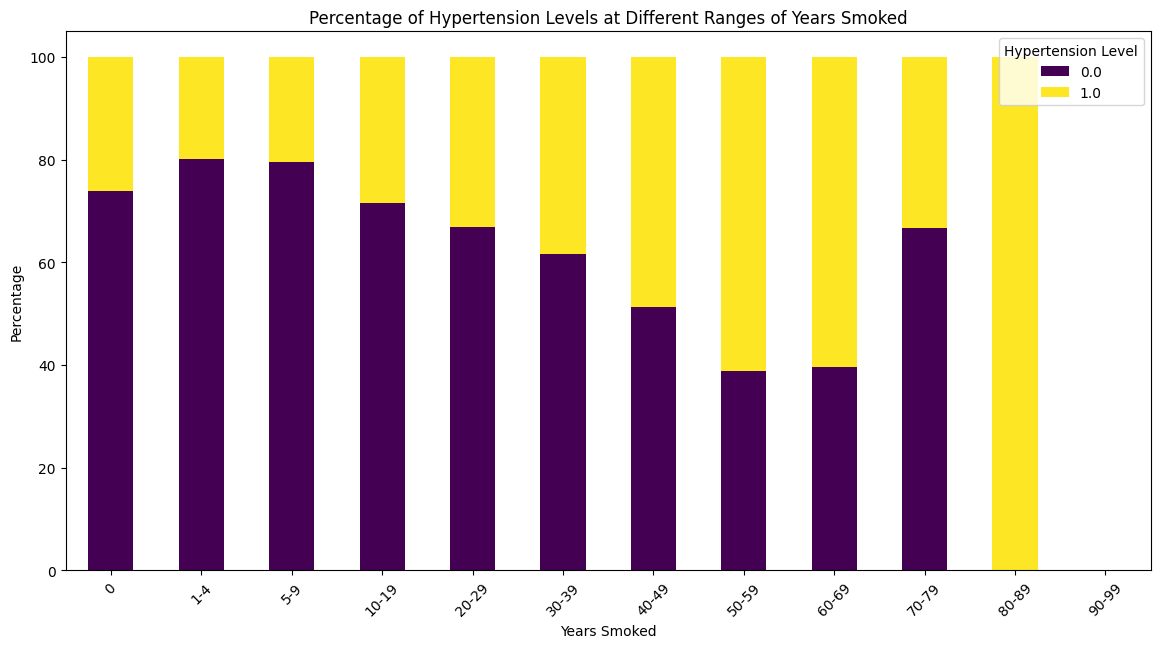

In [123]:
# Bin the yearsSmoked values
bins = [0, 1, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
labels = ['0', '1-4', '5-9', '10-19', '20-29', '30-39', '40-49', '50-59', '60-69', '70-79', '80-89', '90-99']
df['yearsSmokedBinned'] = pd.cut(df['yearsSmoked'], bins=bins, labels=labels, right=False)

# Calculate the percentage of hypertension levels for each bin of yearsSmoked
hypertension_percentage = df.groupby('yearsSmokedBinned')['HypertensionLvl'].value_counts(normalize=True).unstack().fillna(0) * 100

# Plot the data
plt.figure(figsize=(14, 7))
hypertension_percentage.plot(kind='bar', stacked=True, colormap='viridis', ax=plt.gca())
plt.title('Percentage of Hypertension Levels at Different Ranges of Years Smoked')
plt.xlabel('Years Smoked')
plt.ylabel('Percentage')
plt.legend(title='Hypertension Level')
plt.xticks(rotation=45)
plt.show()

### Creating LifetimeCigarettes Feature

In [124]:
# Define the transformation function
def calculate_lifetime_cigarettes(row):
    if row['Smoker'] == 3:
        if pd.isnull(row['WhenSmokedCigs/Day']) | (row['WhenSmokedCigs/Day'] > 100):
            return 0
        return row['yearsSmoked'] * row['WhenSmokedCigs/Day'] * 365
    elif row['Smoker'] in [1, 2]:
        if pd.isnull(row['AvgCigs/DayInLast30']) | (row['AvgCigs/DayInLast30'] > 100):
            return 0
        return row['yearsSmoked'] * row['AvgCigs/DayInLast30'] * row['DaysSmokedInLast30'] /30 * 365
    else:
        return np.nan

# Apply the transformation to create the lifetimeCigarettes feature
df['lifetimeCigarettes'] = df.apply(calculate_lifetime_cigarettes, axis=1)
df15_16['lifetimeCigarettes'] = df15_16.apply(calculate_lifetime_cigarettes, axis=1)

# Verify the changes
print(df[['Smoker', 'yearsSmoked', 'WhenSmokedCigs/Day', 'AvgCigs/DayInLast30', 'DaysSmokedInLast30', 'lifetimeCigarettes']].head(20))

    Smoker  yearsSmoked  WhenSmokedCigs/Day  AvgCigs/DayInLast30  \
0      3.0    49.000000                 2.0                  NaN   
1      2.0    54.000000                 NaN                  1.0   
2      3.0     6.000000                 3.0                  NaN   
4      3.0     0.000000                 NaN                  NaN   
5      3.0    22.000000                 5.0                  NaN   
7      3.0     0.000000                 NaN                  NaN   
8      1.0    23.000000                 NaN                  1.0   
9      1.0    44.000000                 NaN                 25.0   
10     3.0     0.000000                 NaN                  NaN   
12     3.0     0.000000                 NaN                  NaN   
15     3.0     0.000000                 NaN                  NaN   
18     3.0    21.333333                20.0                  NaN   
19     3.0     0.000000                 NaN                  NaN   
21     3.0     0.000000                 NaN     

C:\Users\samco\AppData\Local\Temp\ipykernel_22608\2307530192.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  hypertension_percentage = df.groupby('lifetimeCigarettesBinned')['HypertensionLvl'].value_counts(normalize=True).unstack().fillna(0) * 100


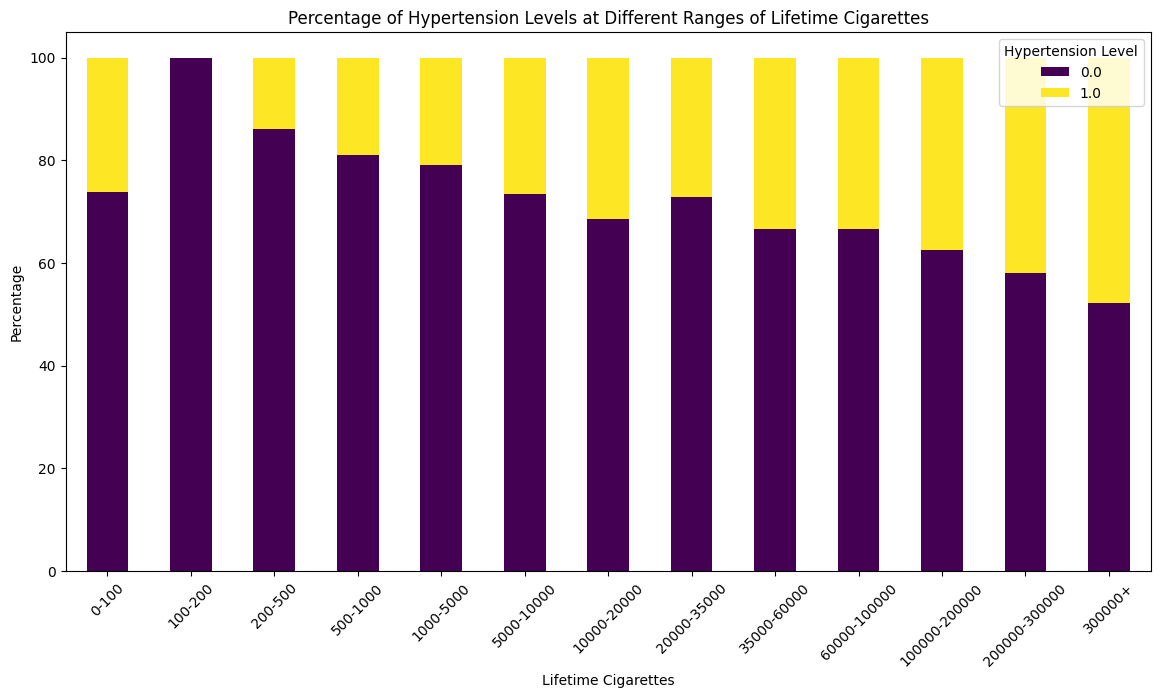

In [125]:
# Bin the lifetimeCigarettes values
bins = [0, 100, 200, 500, 1000, 5000, 10000, 20000, 35000, 60000, 100000, 200000, 300000, 1000000000000]
labels = ['0-100', '100-200', '200-500', '500-1000', '1000-5000', '5000-10000', '10000-20000', '20000-35000', '35000-60000', '60000-100000', '100000-200000', '200000-300000', '300000+']
df['lifetimeCigarettesBinned'] = pd.cut(df['lifetimeCigarettes'], bins=bins, labels=labels, right=False)

# Calculate the percentage of hypertension levels for each bin of lifetimeCigarettes
hypertension_percentage = df.groupby('lifetimeCigarettesBinned')['HypertensionLvl'].value_counts(normalize=True).unstack().fillna(0) * 100

# Plot the data
plt.figure(figsize=(14, 7))
hypertension_percentage.plot(kind='bar', stacked=True, colormap='viridis', ax=plt.gca())
plt.title('Percentage of Hypertension Levels at Different Ranges of Lifetime Cigarettes')
plt.xlabel('Lifetime Cigarettes')
plt.ylabel('Percentage')
plt.legend(title='Hypertension Level')
plt.xticks(rotation=45)
plt.show()

## Alcohol Features

In [126]:
def transform_alc_consump_freq(row):
    if row['UnitAlc'] == 1:
        return (row['AlcConsumpFreq'] * 52)
    elif row['UnitAlc'] == 2:
        return (row['AlcConsumpFreq'] * 12)
    else:
        if (row['AlcConsumpFreq'] > 365):
            return np.nan
        return row['AlcConsumpFreq']
    

df['AlcConsumpFreq'] = df.apply(transform_alc_consump_freq, axis=1)
df15_16['AlcConsumpFreq'] = df15_16.apply(transform_alc_consump_freq, axis=1)

In [127]:
# Set values in 'AlcConsumpAmtPerDrinkDay' to NaN where the condition is met
df.loc[df['AlcConsumpAmtPerDrinkDay'] > 25, 'AlcConsumpAmtPerDrinkDay'] = np.nan
df15_16.loc[df15_16['AlcConsumpAmtPerDrinkDay'] > 25, 'AlcConsumpAmtPerDrinkDay'] = np.nan

# Calculate the new column 'AlcConsump/Yr' by multiplying the relevant columns
df['AlcConsump/Yr'] = df['AlcConsumpAmtPerDrinkDay'] * df['AlcConsumpFreq']
df15_16['AlcConsump/Yr'] = df15_16['AlcConsumpAmtPerDrinkDay'] * df15_16['AlcConsumpFreq']

## Activity Level Features

In [128]:
#Combine vig and mod activity

df['ActivityLvl'] = df.apply(
    lambda row: 1 if row['VigActivity'] == 1 
    else (0.5 if row['VigActivity'] != 1 and row['ModActivity'] == 1 else 0), axis=1
)
df15_16['ActivityLvl'] = df15_16.apply(
    lambda row: 1 if row['VigActivity'] == 1 
    else (0.5 if row['VigActivity'] != 1 and row['ModActivity'] == 1 else 0), axis=1
)

df['WeightedActivity'] = df.apply(
    lambda row: (row['VigActivity'] * 2 if row['VigActivity'] == 1 else 0) + 
                (row['ModActivity'] if row['ModActivity'] == 1 else 0), axis=1
)

df15_16['WeightedActivity'] = df15_16.apply(
    lambda row: (row['VigActivity'] * 2 if row['VigActivity'] == 1 else 0) + 
                (row['ModActivity'] if row['ModActivity'] == 1 else 0), axis=1
)

In [129]:
df = df.dropna(thresh=len(df) - 5000, axis=1)
df15_16 = df15_16.dropna(thresh=len(df15_16) - 2000, axis=1)
df.isnull().sum()

ID                                  0
Gender                              0
Age                                 0
EducationLvl                      607
DiasBP1                           509
DiasBP2                           192
DiasBP3                           185
SysBP1                            509
SysBP2                            192
SysBP3                            185
BMI                               133
Height                            112
Waist                             543
Weight                            109
Cholesterol                       284
SaltFreq                          821
Diabetes                            0
VigActivity                         0
ModActivity                         0
ALQ101                            942
AlcConsumpMoreThan4/5MostDays     949
AlcConsumpFreq                    956
UnitAlc                          2050
AlcConsumpAmtPerDrinkDay          957
100Cigs                           284
Smoker                              0
OvrDietHealt

## Dropping unused features

In [130]:
df = df.drop(columns=['ID', 'DiasBP1', 'DiasBP2', 'DiasBP3', 'SysBP1', 
                      'SysBP2', 'SysBP3', 'AvgDiasBP', 'ALQ101', 'AlcConsumpMoreThan4/5MostDays', 
                      'UnitAlc', 'AlcConsumpAmtPerDrinkDay', '100Cigs', 'yearsSmokedBinned', 'lifetimeCigarettesBinned'])
df15_16 = df15_16.drop(columns=['ID', 'DiasBP1', 'DiasBP2', 'DiasBP3', 'SysBP1',
                                  'SysBP2', 'SysBP3', 'AvgDiasBP', 'ALQ101', 'AlcConsumpMoreThan4/5MostDays',
                                  'UnitAlc', 'AlcConsumpAmtPerDrinkDay', '100Cigs'])
null_values = df.isnull().sum()

In [131]:
df = df.dropna()
df15_16 = df15_16.dropna()

### Removing rows from training that go against the desired trends

In [132]:
# Define the conditions
conditions = (
    (df['Age'] < 45) &
    (df['BMI'] < 26) &
    (df['Waist'] < 130) &
    (df['yearsSmoked'] < 2) &
    (df['WeightedActivity'] > 0) &
    (df['HypertensionLvl'] > 0) &
    (df['AlcConsump/Yr'] < 200)
)

# Filter the DataFrame based on the conditions
filtered_df = df[conditions]

# Drop all rows that meet the conditions
df.drop(df[conditions].index, inplace=True)

In [133]:
conditions = (
    (df['Age'] > 55) &
    (df['BMI'] > 30) &
    (df['yearsSmoked'] > 10) &
    (df['WeightedActivity'] < 1) &
    (df['HypertensionLvl'] == 0) 
)
filtered_df = df[conditions]
df.drop(df[conditions].index, inplace=True)

In [134]:
conditions = (
    (df['Age'] > 55) &
    (df['BMI'] > 30) &
    (df['AlcConsump/Yr'] > 200) &
    (df['WeightedActivity'] < 1) &
    (df['HypertensionLvl'] == 0) 
)
filtered_df = df[conditions]
df.drop(df[conditions].index, inplace=True)

In [135]:
for column in df.columns:
    print(f"Maximum value for {column}: {df[column].max()}")

Maximum value for Gender: 2.0
Maximum value for Age: 80.0
Maximum value for EducationLvl: 9.0
Maximum value for BMI: 82.1
Maximum value for Height: 204.5
Maximum value for Waist: 176.0
Maximum value for Weight: 216.1
Maximum value for Cholesterol: 9.0
Maximum value for SaltFreq: 9.0
Maximum value for Diabetes: 9.0
Maximum value for VigActivity: 2.0
Maximum value for ModActivity: 2.0
Maximum value for AlcConsumpFreq: 365.0
Maximum value for Smoker: 3.0
Maximum value for OvrDietHealth: 9.0
Maximum value for GenHealth: 5.0
Maximum value for AvgSysBP: 234.66666666666666
Maximum value for HypertensionLvl: 1.0
Maximum value for yearsSmoked: 80.0
Maximum value for lifetimeCigarettes: 1606000.0
Maximum value for AlcConsump/Yr: 6552.0
Maximum value for ActivityLvl: 1.0
Maximum value for WeightedActivity: 3.0


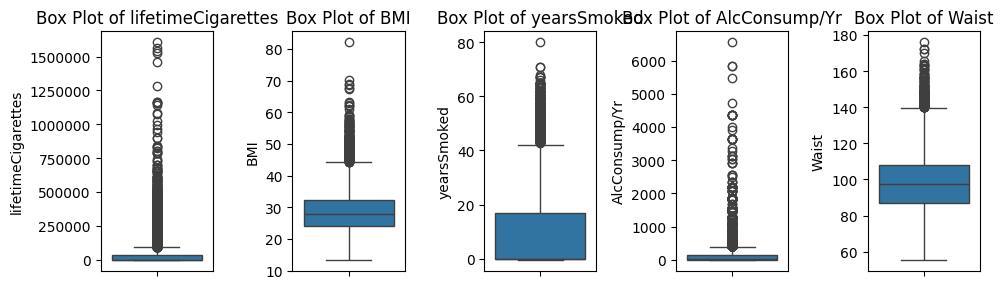

In [136]:
# Create a figure and axis
fig, ax = plt.subplots(1, 5, figsize=(10, 3))

# Create a box plot for Age
sns.boxplot(y=df['lifetimeCigarettes'], ax=ax[0])
ax[0].set_title('Box Plot of lifetimeCigarettes')

ax[0].yaxis.set_major_formatter(ScalarFormatter(useOffset=False))
ax[0].ticklabel_format(style='plain', axis='y')

# Create a box plot for BMI
sns.boxplot(y=df['BMI'], ax=ax[1])
ax[1].set_title('Box Plot of BMI')

sns.boxplot(y=df['yearsSmoked'], ax=ax[2])
ax[2].set_title('Box Plot of yearsSmoked')

sns.boxplot(y=df['AlcConsump/Yr'], ax=ax[3])
ax[3].set_title('Box Plot of AlcConsump/Yr')

sns.boxplot(y=df['Waist'], ax=ax[4])
ax[4].set_title('Box Plot of Waist')

# Display the plots
plt.tight_layout()
plt.show()

### Setting outlier values to a value that maintain the relationship but will not negatively affect models

In [137]:
# Cap lifetimeCigarettes at 400,000
df.loc[df['lifetimeCigarettes'] > 400000, 'lifetimeCigarettes'] = 400000
df15_16.loc[df15_16['lifetimeCigarettes'] > 400000, 'lifetimeCigarettes'] = 400000

# Cap BMI at 45
df.loc[df['BMI'] > 45, 'BMI'] = 45
df15_16.loc[df15_16['BMI'] > 45, 'BMI'] = 45

# Cap yearsSmoked at 45
df.loc[df['yearsSmoked'] > 45, 'yearsSmoked'] = 45
df15_16.loc[df15_16['yearsSmoked'] > 45, 'yearsSmoked'] = 45

# Cap AlcConsump/Yr at 900
df.loc[df['AlcConsump/Yr'] > 900, 'AlcConsump/Yr'] = 900
df15_16.loc[df15_16['AlcConsump/Yr'] > 900, 'AlcConsump/Yr'] = 900

# Cap waist at 150 and set minimum waist to 60
df.loc[df['Waist'] > 150, 'Waist'] = 150
df15_16.loc[df15_16['Waist'] > 150, 'Waist'] = 150
df.loc[df['Waist'] < 60, 'Waist'] = 60
df15_16.loc[df15_16['Waist'] < 60, 'Waist'] = 60

### Fixing any refused-to-answer fields

In [138]:
# Set Cholesterol, SaltFreq, Diabetes, OvrDietHealth to their mode when they equal 9
for column in ['Cholesterol', 'SaltFreq', 'Diabetes', 'OvrDietHealth', 'EducationLvl']:
    if not df[column].dropna().empty:  # Check if column is not entirely NaN or empty
        mode_value = df[column].mode()
        if not mode_value.empty:  # Check if mode calculation returned a value
            mode_value = mode_value[0]
            df.loc[(df[column] == 9) | (df[column] == 7), column] = mode_value
        else:
            print(f"No mode found for {column}.")
    else:
        print(f"Column {column} is empty or has only NaN values.")

for column in ['Cholesterol', 'SaltFreq', 'Diabetes', 'OvrDietHealth', 'EducationLvl']:
    if not df15_16[column].dropna().empty:  # Check if column is not entirely NaN or empty
        mode_value = df15_16[column].mode()
        if not mode_value.empty:  # Check if mode calculation returned a value
            mode_value = mode_value[0]
            df15_16.loc[(df[column] == 9) | (df15_16[column] == 7), column] = mode_value
        else:
            print(f"No mode found for {column}.")
    else:
        print(f"Column {column} is empty or has only NaN values.")


# Set YearsSmoked and LifetimeCigarettes to 0 if they are less than 0
df.loc[df['yearsSmoked'] < 0, 'yearsSmoked'] = 0
df15_16.loc[df15_16['yearsSmoked'] < 0, 'yearsSmoked'] = 0
df.loc[df['lifetimeCigarettes'] < 0, 'lifetimeCigarettes'] = 0
df15_16.loc[df15_16['lifetimeCigarettes'] < 0, 'lifetimeCigarettes'] = 0

## Encoding

In [139]:
# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Fit and transform the DataFrame
df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)
df_scaled15_16 = pd.DataFrame(scaler.fit_transform(df15_16), columns=df.columns)

# Print the first few rows of the scaled DataFrame to verify
print(df_scaled.head())

   Gender       Age  EducationLvl       BMI    Height     Waist    Weight  \
0     0.0  0.816667          0.50  0.420886  0.525714  0.444444  0.263102   
1     0.0  0.566667          0.50  0.481013  0.604286  0.528889  0.322995   
2     0.0  0.866667          0.75  0.490506  0.582857  0.546667  0.319786   
3     0.0  0.600000          0.75  0.895570  0.345714  0.701111  0.405882   
4     1.0  0.683333          1.00  0.705696  0.390000  0.564444  0.343850   

   Cholesterol  SaltFreq  Diabetes  ...  Smoker  OvrDietHealth  GenHealth  \
0          0.0  1.000000       0.0  ...     1.0           0.25       0.25   
1          0.0  0.666667       0.0  ...     0.5           0.50       0.75   
2          0.0  0.333333       0.0  ...     1.0           0.50       0.50   
3          0.0  0.666667       0.5  ...     1.0           1.00       1.00   
4          1.0  0.000000       0.5  ...     1.0           0.75       0.50   

   AvgSysBP  HypertensionLvl  yearsSmoked  lifetimeCigarettes  AlcConsump/

In [140]:
df_scaled = df_scaled.dropna()
df_scaled15_16 = df_scaled15_16.dropna()

null_values = df_scaled.isnull().sum()
print("Null values in each column:")

Null values in each column:


In [141]:
# #'AlcConsumpFreq', 'AlcConsumpAmtPerDrinkDay', 'AlcConsump/Yr', 'lifetimeCigarettes'
# df['BMI'] = 1 / (1 + np.exp(-20 * (df['BMI'] - 0.6)))

# df['AlcConsumpFreq'] = 1 / (1 + np.exp(-8 * (df['AlcConsumpFreq'] - 0.5)))

# df['AlcConsump/Yr'] = 1 / (1 + np.exp(-15 * (df['AlcConsump/Yr'] - 0.5)))

# df['lifetimeCigarettes'] = 1 / (1 + np.exp(-15 * (df['lifetimeCigarettes'] - 0.5)))

### Splitting Target

In [142]:
# Create the target variable
target = df_scaled['HypertensionLvl']
target_15_16 = df_scaled15_16['HypertensionLvl']

# Drop the HypertensionLvl column from the DataFrame
df_scaled = df_scaled.drop(columns=['HypertensionLvl', 'AvgSysBP', 'VigActivity', 'ModActivity', 'BMI', 'ActivityLvl'])
df_scaled15_16 = df_scaled15_16.drop(columns=['HypertensionLvl', 'AvgSysBP', 'VigActivity', 'ModActivity', 'BMI', 'ActivityLvl'])

In [143]:
df_scaled.columns

Index(['Gender', 'Age', 'EducationLvl', 'Height', 'Waist', 'Weight',
       'Cholesterol', 'SaltFreq', 'Diabetes', 'AlcConsumpFreq', 'Smoker',
       'OvrDietHealth', 'GenHealth', 'yearsSmoked', 'lifetimeCigarettes',
       'AlcConsump/Yr', 'WeightedActivity'],
      dtype='object')

### Train-Test-Split

In [144]:
X_train, X_test, Y_train, Y_test = train_test_split(df_scaled, target, test_size=0.35, random_state=42)

# Print the shapes of the resulting splits to verify
print("Training set shape:", X_train.shape)
print("Test set shape:", X_test.shape)
print("Training target shape:", Y_train.shape)
print("Test target shape:", Y_test.shape)

Training set shape: (5616, 17)
Test set shape: (3024, 17)
Training target shape: (5616,)
Test target shape: (3024,)


## Models

In [145]:
def evaluate_model(model, X_train, X_test, Y_train, Y_test):
    # Train the model
    model.fit(X_train, Y_train)
    
    # Make predictions
    # y_pred = model.predict(X_test)
    
    # Check if the model supports predict_proba (required for AUC)
    if hasattr(model, "predict_proba"):
        y_pred_proba = model.predict_proba(X_test)[:, 1]  # Get probabilities for the positive class
        y_pred = (y_pred_proba > 0.4).astype(int)
    else:
        print("Model does not support probability predictions; AUC cannot be calculated.")
        y_pred_proba = None
    
    # Calculate accuracy
    accuracy = accuracy_score(Y_test, y_pred)
    print(f"Accuracy: {accuracy:.5f}")

    recall = recall_score(Y_test, y_pred)
    print(f"Recall: {recall:.5f}")

    # Create a DataFrame to compare predictions with actual results
    comparison_df = pd.DataFrame({
        'Actual': Y_test,
        'Predicted': y_pred
    })

    # Add predicted probabilities if available
    if y_pred_proba is not None:
        comparison_df['Predicted_Probability'] = y_pred_proba

    # Print the comparison DataFrame
    print("\nComparison DataFrame:")
    print(comparison_df.to_string())

    # Calculate AUC score if probabilities are available
    if y_pred_proba is not None:
        auc = roc_auc_score(Y_test, y_pred_proba)
        print(f"AUC Score: {auc:.5f}")

        # Plot ROC curve
        fpr, tpr, _ = roc_curve(Y_test, y_pred_proba)
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, label=f'AUC = {auc:.5f}')
        plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for random classifier
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve')
        plt.legend(loc='lower right')
        plt.show()
    else:
        print("AUC and ROC Curve cannot be plotted as the model does not provide probability estimates.")

## Logistic Regression

Accuracy: 0.73578
Recall: 0.61329

Comparison DataFrame:
      Actual  Predicted  Predicted_Probability
6805     0.0          0               0.206632
4570     1.0          0               0.082565
222      1.0          1               0.662178
3984     1.0          1               0.711536
318      0.0          0               0.060098
6712     0.0          0               0.291367
736      0.0          0               0.064557
7957     0.0          0               0.369667
8162     0.0          0               0.172622
3469     0.0          1               0.403811
8607     1.0          1               0.503451
3616     0.0          0               0.187785
1263     0.0          0               0.352808
4709     0.0          0               0.350211
4827     1.0          1               0.590755
1426     0.0          0               0.043832
5522     1.0          0               0.290913
5608     1.0          0               0.353881
8234     0.0          0               0.376949
652

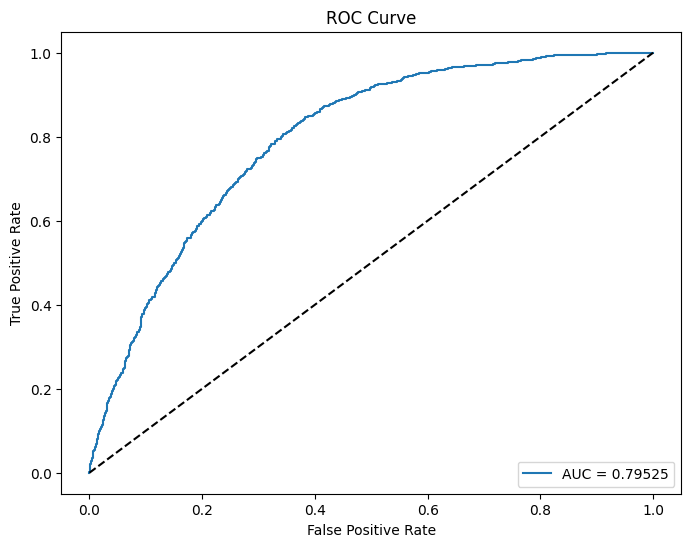

In [146]:
LR_model = LogisticRegression(max_iter=1000)
evaluate_model(LR_model, X_train, X_test, Y_train, Y_test)

## Random Forest

Accuracy: 0.72057
Recall: 0.64706

Comparison DataFrame:
      Actual  Predicted  Predicted_Probability
6805     0.0          0                   0.30
4570     1.0          0                   0.25
222      1.0          1                   0.62
3984     1.0          1                   0.70
318      0.0          0                   0.23
6712     0.0          1                   0.41
736      0.0          0                   0.03
7957     0.0          1                   0.41
8162     0.0          0                   0.24
3469     0.0          1                   0.54
8607     1.0          1                   0.62
3616     0.0          0                   0.16
1263     0.0          1                   0.46
4709     0.0          1                   0.45
4827     1.0          1                   0.66
1426     0.0          0                   0.20
5522     1.0          0                   0.37
5608     1.0          0                   0.37
8234     0.0          0                   0.17
652

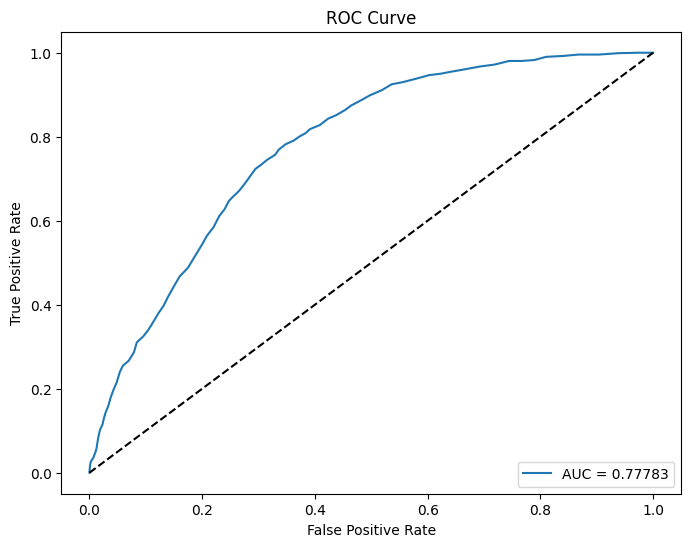

In [147]:
RF_model = RandomForestClassifier(n_estimators=100, random_state=42)
evaluate_model(RF_model, X_train, X_test, Y_train, Y_test)

Accuracy: 0.72983
Recall: 0.67211

Comparison DataFrame:
      Actual  Predicted  Predicted_Probability
6805     0.0          0               0.238022
4570     1.0          0               0.239772
222      1.0          1               0.602231
3984     1.0          1               0.643419
318      0.0          0               0.154213
6712     0.0          1               0.420371
736      0.0          0               0.030624
7957     0.0          1               0.415094
8162     0.0          0               0.144010
3469     0.0          1               0.498488
8607     1.0          1               0.624529
3616     0.0          0               0.130198
1263     0.0          1               0.422906
4709     0.0          1               0.467913
4827     1.0          1               0.539194
1426     0.0          0               0.112856
5522     1.0          1               0.404466
5608     1.0          0               0.361173
8234     0.0          0               0.199354
652

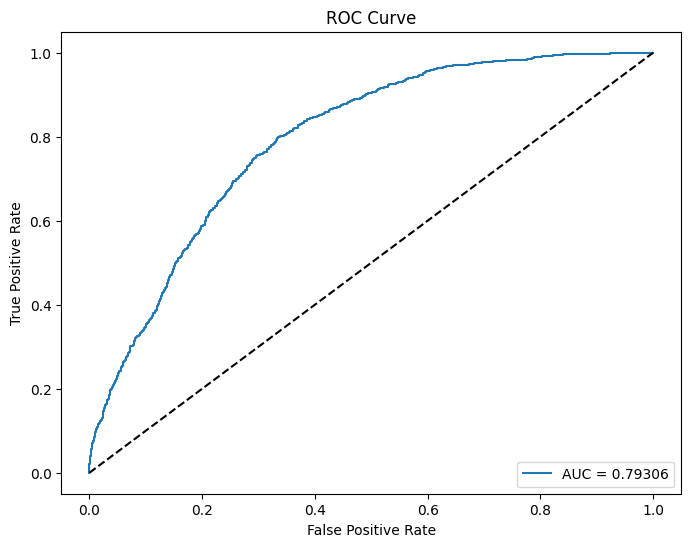

In [148]:
# Define the hyperparameters
rf_params = {
    'n_estimators': 500,
    'min_samples_split': 5,
    'min_samples_leaf': 4,
    'max_features': 'sqrt',
    'max_depth': 10,
    'bootstrap': True
}

# Initialize the Random Forest classifier with the given hyperparameters
rf_model = RandomForestClassifier(**rf_params, random_state=42)

evaluate_model(rf_model, X_train, X_test, Y_train, Y_test)

## Catboost Classifier

Accuracy: 0.72586
Recall: 0.64052

Comparison DataFrame:
      Actual  Predicted  Predicted_Probability
6805     0.0          0               0.222772
4570     1.0          0               0.308126
222      1.0          1               0.521947
3984     1.0          1               0.686816
318      0.0          0               0.179069
6712     0.0          1               0.457352
736      0.0          0               0.037131
7957     0.0          1               0.622763
8162     0.0          0               0.122368
3469     0.0          1               0.488030
8607     1.0          1               0.736124
3616     0.0          0               0.184875
1263     0.0          0               0.382225
4709     0.0          1               0.558061
4827     1.0          1               0.540581
1426     0.0          0               0.061604
5522     1.0          0               0.293903
5608     1.0          1               0.423276
8234     0.0          0               0.300863
652

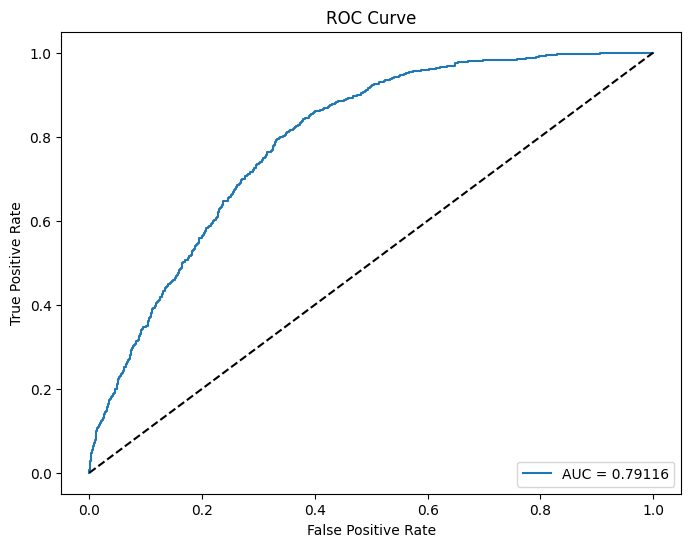

In [149]:
catboost_model = CatBoostClassifier(verbose=0, random_state=42, cat_features=df.select_dtypes(include=['object', 'category']).columns.tolist())
evaluate_model(catboost_model, X_train, X_test, Y_train, Y_test)

## Neural Network 

c:\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


Accuracy: 0.73115
Recall: 0.60458

Comparison DataFrame:
      Actual  Predicted  Predicted_Probability
6805     0.0          0               0.218302
4570     1.0          0               0.130097
222      1.0          1               0.619536
3984     1.0          1               0.719794
318      0.0          0               0.023759
6712     0.0          0               0.197625
736      0.0          0               0.031000
7957     0.0          0               0.362151
8162     0.0          0               0.183922
3469     0.0          0               0.396099
8607     1.0          1               0.464896
3616     0.0          0               0.191600
1263     0.0          0               0.382429
4709     0.0          0               0.380890
4827     1.0          1               0.654995
1426     0.0          0               0.043182
5522     1.0          0               0.322088
5608     1.0          0               0.335596
8234     0.0          0               0.395797
652

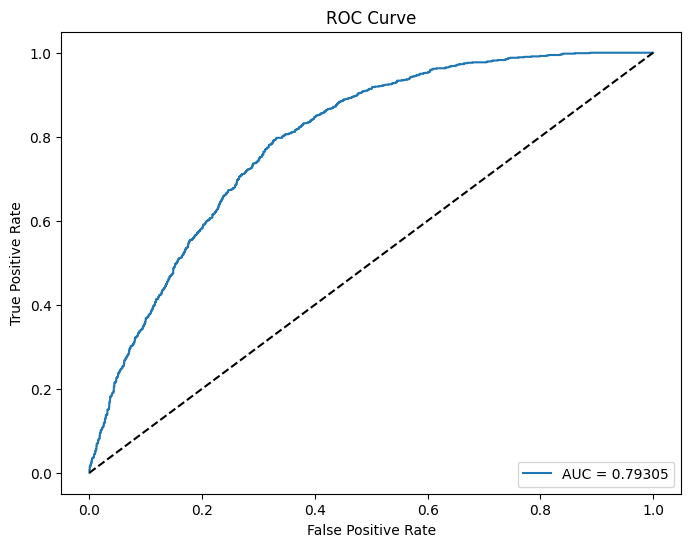

In [150]:
nn_model = MLPClassifier(hidden_layer_sizes=(20,), activation='relu', solver='adam', max_iter=100, random_state=42)
evaluate_model(nn_model, X_train, X_test, Y_train, Y_test)

In [151]:
# # Define the initial neural network model
# nn_model = MLPClassifier(random_state=42)

# # Define a more extensive parameter grid for random search
# param_distributions = {
#     'hidden_layer_sizes': [ (20,), (50,), (100,), (150,), (50, 50), (100, 50), (100, 100),],  # More layer combinations
#     'activation': ['tanh', 'logistic', 'identity'],  # Different activation functions
#     'solver': ['adam', 'sgd'],  # Solvers for weight optimization
#     'alpha': np.logspace(-5, -1, 5),  # L2 penalty (regularization) term
#     'learning_rate': ['constant', 'invscaling', 'adaptive'],  # Learning rate schedules
#     'learning_rate_init': np.logspace(-4, -1, 4),  # Initial learning rate
#     'max_iter': [100, 200, 300],  # Number of epochs
#     'batch_size': [16, 32],  # Size of minibatches
#     'momentum': [0.9, 0.95],  # Momentum for SGD solver
#     'nesterovs_momentum': [True, False],  # Whether to use Nesterov's momentum
#     'early_stopping': [True, False],  # Whether to use early stopping to terminate training
#     'beta_1': [0.8, 0.9],  # Exponential decay rate for estimates of first moment vector in adam
#     'beta_2': [0.9, 0.99],  # Exponential decay rate for estimates of second moment vector in adam
# }

# # Set up the RandomizedSearchCV
# random_search = RandomizedSearchCV(
#     estimator=nn_model,
#     param_distributions=param_distributions,
#     n_iter=70,  # Number of parameter settings sampled
#     scoring='roc_auc',  # Scoring metric to use
#     n_jobs=-1,  # Use all available cores
#     cv=5,  # 5-fold cross-validation
#     verbose=3,  # Verbosity level
#     random_state=42  # Random state for reproducibility
# )

# # Assuming your data is already prepared in X_train and Y_train
# # Perform the random search
# random_search.fit(X_train, Y_train)

# # Print the best parameters and the best score from the random search
# print("Best parameters found by random search:")
# print(random_search.best_params_)

# print("\nBest AUC score from random search:")
# print(f"{random_search.best_score_:.5f}")

# # Optionally, evaluate the best model using your evaluation function
# best_nn_model = random_search.best_estimator_
# evaluate_model(best_nn_model, X_train, X_test, Y_train, Y_test)

### Hyperparameter Tuning for Catboost

In [152]:
# # Initialize CatBoostClassifier
# catboost_model = CatBoostClassifier(verbose=0, random_state=42, cat_features=df.select_dtypes(include=['object', 'category']).columns.tolist())

# # Define the hyperparameter grid
# param_grid = {
#     'iterations': [100, 200, 300],
#     'depth': [4, 6, 8],
#     'learning_rate': [0.01, 0.1, 0.2],
#     'l2_leaf_reg': [1, 3, 5, 7],
#     'border_count': [32, 64, 128]
# }

# # Set up GridSearchCV
# grid_search = GridSearchCV(estimator=catboost_model, param_grid=param_grid, cv=3, scoring='accuracy', n_jobs=-1)

# # Fit GridSearchCV
# grid_search.fit(X_train, Y_train)

# # Get the best model from grid search
# best_catboost_model = grid_search.best_estimator_

# # Train the model with the best parameters
# best_catboost_model.fit(X_train, Y_train)

# # Evaluate the best model using the provided evaluate_model function
# evaluate_model(best_catboost_model, X_train, X_test, Y_train, Y_test)

# # Output best parameters
# print("Best parameters found: ", grid_search.best_params_)

Accuracy: 0.73611
Recall: 0.65359

Comparison DataFrame:
      Actual  Predicted  Predicted_Probability
6805     0.0          0               0.199426
4570     1.0          0               0.227506
222      1.0          1               0.611735
3984     1.0          1               0.634545
318      0.0          0               0.108125
6712     0.0          0               0.314191
736      0.0          0               0.059253
7957     0.0          0               0.372096
8162     0.0          0               0.143040
3469     0.0          1               0.433840
8607     1.0          1               0.606054
3616     0.0          0               0.146090
1263     0.0          1               0.432216
4709     0.0          1               0.493800
4827     1.0          1               0.576893
1426     0.0          0               0.100265
5522     1.0          1               0.402896
5608     1.0          1               0.447121
8234     0.0          0               0.226475
652

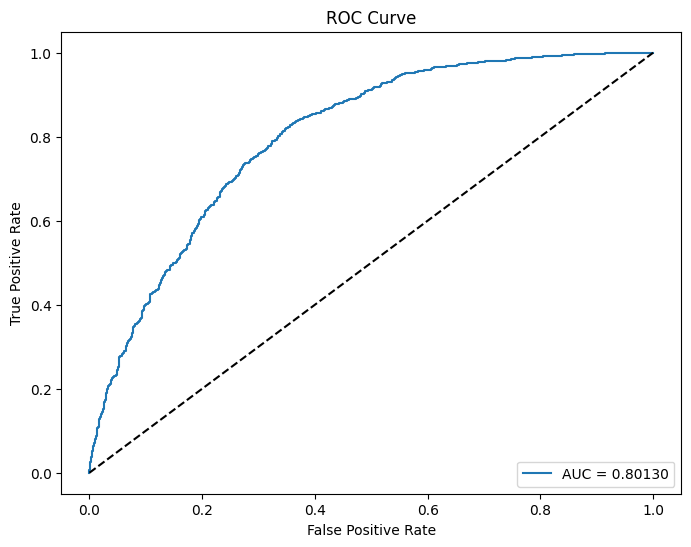

Best parameters found:  {'border_count': 128, 'depth': 3, 'iterations': 500, 'l2_leaf_reg': 5, 'learning_rate': 0.01}


In [153]:
#'scale_pos_weight': 1, 'random_strength': 1.0, 'learning_rate': 0.01, 'l2_leaf_reg': 5, 'iterations': 500, 'depth': 3, 'border_count': 128, 'bagging_temperature': 0.0}
# Initialize CatBoostClassifier
catboost_model = CatBoostClassifier(verbose=0, random_state=42, cat_features=df.select_dtypes(include=['object', 'category']).columns.tolist())

# Define the hyperparameter grid
param_grid = {
    'iterations': [100, 200, 300],
    'depth': [4, 6, 8],
    'learning_rate': [0.01, 0.1, 0.2],
    'l2_leaf_reg': [1, 3, 5, 7],
    'border_count': [32, 64, 128]
}

# Set up GridSearchCV
# grid_search = GridSearchCV(estimator=catboost_model, param_grid=param_grid, cv=3, scoring='accuracy', n_jobs=-1)

# Fit GridSearchCV
# grid_search.fit(X_train, Y_train)

# Get the best model from grid search
# best_catboost_model = grid_search.best_estimator_

# Manually set the best parameters
best_params = {'border_count': 128, 'depth': 3, 'iterations': 500, 'l2_leaf_reg': 5, 'learning_rate': 0.01}
best_catboost_model = CatBoostClassifier(verbose=0, random_state=42, cat_features=df.select_dtypes(include=['object', 'category']).columns.tolist(), **best_params)

# Train the model with the best parameters
best_catboost_model.fit(X_train, Y_train)

# Evaluate the best model using the provided evaluate_model function
evaluate_model(best_catboost_model, X_train, X_test, Y_train, Y_test)

# Output best parameters
print("Best parameters found: ",best_params)

## External Data Test

In [154]:
# Predict probabilities on df_scaled_11_12
pred_prob = best_catboost_model.predict_proba(df_scaled15_16)[:, 1]

# Predict classes based on a probability threshold of 0.4
pred_class = (pred_prob > 0.4).astype(int)

# Calculate accuracy
accuracy = accuracy_score(target_15_16, pred_class)

# Calculate AUC score
auc_score = roc_auc_score(target_15_16, pred_prob)

# Create a DataFrame with prediction probability, actual result, and predicted result
results_df = pd.DataFrame({
    'Prediction Probability': pred_prob,
    'Actual Result': target_15_16,
    'Predicted Result': pred_class
})

# Output the results
print("Accuracy: ", accuracy)
print("AUC Score: ", auc_score)
print("Results DataFrame:")
print(results_df.to_string())

Accuracy:  0.6953569864213753
AUC Score:  0.7498031279633149
Results DataFrame:
      Prediction Probability  Actual Result  Predicted Result
0                   0.511672            0.0               1.0
1                   0.521749            1.0               1.0
2                   0.668179            1.0               1.0
3                   0.460282            1.0               0.0
4                   0.164010            0.0               0.0
5                   0.598599            0.0               1.0
6                   0.131934            0.0               0.0
7                   0.092473            0.0               0.0
8                   0.480657            1.0               0.0
9                   0.292554            1.0               0.0
10                  0.213453            0.0               0.0
11                  0.104055            0.0               0.0
12                  0.606901            0.0               1.0
13                  0.581921            1.0         